# 성능 최적화


## Hyperparameter Tuning

### Grid Search VS Random Search

Grid Search: 값의 범위 지정 -> 값의 범위 내에서 bruteforce -> 최고 성능값 선정
Random Search: 값의 범위 + 시도 횟수 지정 -> 값의 범위 내에서 시도 횟수만큼만 랜덤 선택해서 시도 -> 최고 성능값 선정

### 주의사항

운영환경별로 성능이 달라질 수 있음
미래에 발생한 데이터를 추가할 경우 최적값이 달라질 가능성이 높음.
미래에 발생하는 데이터의 양상이 과거와 크게 달라질 가능성이 높음.

### 모델링의 본질적인 목표
완벽한 예측이 아닌, 적절한 예측을 얻기 위해 적절한 복잡도의 모델을 생성해야 함.
Heuristic적인 부분이 굉장히 많음

### Overfitting(과적합)
과거의 데이터를 너무 완벽하게 맞추려고 노력하다보면 현재의 데이터, 또는 미래의 데이터와는 잘 맞지 않을 가능성 또한 존재.
과거, 현재, 미래의 데이터와 모두 잘 맞을 수 있는 모델을 만드는 것이 중요함


## 1.데이터 준비

### (1) 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

### (2) 데이터 업로드

In [2]:
# mobile data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv"
data = pd.read_csv(path)
data.drop(['id', 'REPORTED_USAGE_LEVEL','OVER_15MINS_CALLS_PER_MONTH'], axis = 1, inplace = True)
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,4,unsat,no,STAY
1,1,36147,0,13,800586,244,6,unsat,considering,STAY
2,1,27273,230,0,305049,201,15,unsat,perhaps,STAY
3,0,120070,38,33,788235,780,2,unsat,considering,LEAVE
4,1,29215,208,85,224784,241,1,very_unsat,never_thought,STAY


|변수 명|내용|구분|
|----|----|----|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


In [3]:
# 데이터분할1
target = 'CHURN'
x = data.drop(target, axis=1)
y = data.loc[:, target]

# 가변수화
dumm_cols = ['REPORTED_SATISFACTION','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

# 데이터 분할2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.4, random_state = 20)

# 스케일링
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

## 2.모델링

### (1) Random Search

작업 순서

    1) 파라미터의 범위 지정
    2) 함수 불러오기
        - 알고리즘
        - Random Search
    3) 모델 선언
        - 기본 모델
        - Random Search 모델
    4) 학습
    5) 예측
    6) 평가



In [ ]:
# 1) random하게 찾을 범위를 지정
# 지정하지 않는 파라미터는 default 값으로 지정됨.
# 1) 파라미터를 dictionary형태로 선언
rand_param = { 'n_neighbors' : [3,5,7,9,11,13,15,17,19]  # 9
                , 'metric' : ['euclidean', 'manhattan']  # 2
}

rand_param # 총 18가지 경우의 수가 나옴

{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
 'metric': ['euclidean', 'manhattan']}

In [ ]:
# 2) 함수 불러오기
from sklearn.neighbors import KNeighborsClassifier

# Random Search를 수행해 줄 함수!
from sklearn.model_selection import RandomizedSearchCV #(Cross Validation까지 함께 수행)

In [6]:
# 3) 모델선언
# 기본모델
knn_model = KNeighborsClassifier()

# Random Search 설정.
rand_model = RandomizedSearchCV(knn_model
                        , rand_param              # hyperparameter 범위 지정.
                        , cv=5                    # k-fold Cross Validation
                        , scoring='accuracy'
                        , n_iter=5                # Random하게 시도할 횟수
                        )

In [ ]:
# 4) 학습 : knn_model이 아니라 rand_model
rand_model.fit(x_train_s, y_train)

# n_neighbors 는 19, metric 은 manhattan일 때 가장 성능이 우수했음을 알 수 있다.

,estimator,KNeighborsClassifier()
,param_distributions,"{'metric': ['euclidean', 'manhattan'], 'n_neighbors': [3, 5, ...]}"
,n_iter,5
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [ ]:
# 시행에 대한 정보(result)
rand_model.cv_results_

{'mean_fit_time': array([0.06171451, 0.06608171, 0.05643148, 0.05385351, 0.05774846]),
 'std_fit_time': array([0.01009789, 0.0173523 , 0.00479226, 0.00207685, 0.0038908 ]),
 'mean_score_time': array([0.35476871, 0.60463953, 0.43719797, 0.30249372, 0.44364085]),
 'std_score_time': array([0.07374018, 0.23890832, 0.06988088, 0.06329331, 0.07046435]),
 'param_n_neighbors': masked_array(data=[11, 19, 13, 3, 19],
              mask=[False, False, False, False, False],
        fill_value=999999),
 'param_metric': masked_array(data=['euclidean', 'manhattan', 'manhattan', 'euclidean',
                    'euclidean'],
              mask=[False, False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'n_neighbors': 11, 'metric': 'euclidean'},
  {'n_neighbors': 19, 'metric': 'manhattan'},
  {'n_neighbors': 13, 'metric': 'manhattan'},
  {'n_neighbors': 3, 'metric': 'euclidean'},
  {'n_neighbors': 19, 'metric': 'euclidean'}],
 'split0_test_score': arra

In [ ]:
# 최적의 파라미터(최적의 parameter들을 dict로 반환)
rand_model.best_params_

{'n_neighbors': 19, 'metric': 'manhattan'}

In [ ]:
# 최적의 성능 (r2)
rand_model.best_score_

np.float64(0.651)

In [11]:
# 5) 예측 및 평가
pred = rand_model.predict(x_val_s)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [13]:
print(confusion_matrix(y_val, pred))

[[2374 1526]
 [1283 2817]]


In [14]:
print(classification_report(y_val, pred, digits = 4))

              precision    recall  f1-score   support

       LEAVE     0.6492    0.6087    0.6283      3900
        STAY     0.6486    0.6871    0.6673      4100

    accuracy                         0.6489      8000
   macro avg     0.6489    0.6479    0.6478      8000
weighted avg     0.6489    0.6489    0.6483      8000



### (2) Grid Search

* random search는 범위 내에서 무작위로 수행하는 반면
* grid search는 범위 내의 모든 경우의 수 만큼 수행

작업 순서

    1) 파라미터의 범위 지정
    2) 함수 불러오기
        - 알고리즘
        - Grid Search
    3) 모델 선언
        - 모델
        - Grid Search
    4) 학습
    5) 예측
    6) 평가



In [15]:
# 1) 파라미터를 dictionary형태로 선언
grid_param = {
    'n_neighbors' : list(range(2,70, 3))
    , 'metric' : ['euclidean', 'manhattan']
}
grid_param

{'n_neighbors': [2,
  5,
  8,
  11,
  14,
  17,
  20,
  23,
  26,
  29,
  32,
  35,
  38,
  41,
  44,
  47,
  50,
  53,
  56,
  59,
  62,
  65,
  68],
 'metric': ['euclidean', 'manhattan']}

In [16]:
# 2) 함수 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV  # 이번엔 GridSearchCV

In [18]:
# 3) 모델 선언
knn = KNeighborsClassifier()

knn_gs = GridSearchCV(knn,
                    grid_param,
                    cv = 3    # k-fold cross validation
                    ) # scoring을 생략하면, 기본값으로 분류는 accuracy, 회귀는 r2_score

In [ ]:
# 4) 학습 :
knn_gs.fit(x_train_s, y_train)


,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan'], 'n_neighbors': [2, 5, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,65


In [20]:
# 최적의 파라미터를 찾아준다.
knn_gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 65}

In [ ]:
knn_gs.best_score_

np.float64(0.6585833333333332)

In [22]:
# 5) 예측 및 평가
pred = knn_gs.predict(x_val_s)
accuracy_score(y_val, pred)

0.648875

In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred  ))

[[2237 1663]
 [1146 2954]]


In [24]:
print(classification_report(y_val, pred  ))

              precision    recall  f1-score   support

       LEAVE       0.66      0.57      0.61      3900
        STAY       0.64      0.72      0.68      4100

    accuracy                           0.65      8000
   macro avg       0.65      0.65      0.65      8000
weighted avg       0.65      0.65      0.65      8000



* 튜닝 결과를 데이터프레임으로 저장

In [25]:
knn_gs.cv_results_

{'mean_fit_time': array([0.04793366, 0.04546205, 0.05081813, 0.04866552, 0.05488292,
        0.05760225, 0.06095346, 0.05483826, 0.05362741, 0.05255437,
        0.05795193, 0.05091548, 0.05284882, 0.05756903, 0.05838656,
        0.05434283, 0.04904215, 0.0477732 , 0.0540669 , 0.05500881,
        0.04965154, 0.06365935, 0.05156215, 0.05170981, 0.05191811,
        0.04830527, 0.04734095, 0.04809475, 0.04955983, 0.04856253,
        0.05397042, 0.04854743, 0.04839897, 0.04886174, 0.04759026,
        0.05023201, 0.05039088, 0.04719305, 0.04656029, 0.04787119,
        0.04869246, 0.04810437, 0.04757969, 0.04617643, 0.04066682,
        0.04770025]),
 'std_fit_time': array([4.99099192e-03, 1.44566820e-03, 6.69413826e-03, 3.70882607e-03,
        2.58194068e-03, 1.39672341e-03, 1.18433492e-02, 6.38047894e-03,
        2.97873149e-03, 3.63069269e-03, 2.72898887e-03, 9.58664732e-04,
        3.90566382e-03, 7.57365390e-03, 1.45193455e-03, 3.02314183e-03,
        4.73677992e-04, 2.05534916e-04, 4.400

In [26]:
result = pd.DataFrame(knn_gs.cv_results_)

In [27]:
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047934,0.004991,0.507401,0.109886,euclidean,2,"{'metric': 'euclidean', 'n_neighbors': 2}",0.59775,0.59700,0.59550,0.596750,0.000935,46
1,0.045462,0.001446,0.565049,0.106395,euclidean,5,"{'metric': 'euclidean', 'n_neighbors': 5}",0.63575,0.63475,0.62225,0.630917,0.006142,43
2,0.050818,0.006694,0.760644,0.179496,euclidean,8,"{'metric': 'euclidean', 'n_neighbors': 8}",0.63950,0.63100,0.62250,0.631000,0.006940,42
3,0.048666,0.003709,0.791104,0.212852,euclidean,11,"{'metric': 'euclidean', 'n_neighbors': 11}",0.64575,0.64675,0.62850,0.640333,0.008377,21
4,0.054883,0.002582,0.889303,0.167413,euclidean,14,"{'metric': 'euclidean', 'n_neighbors': 14}",0.64175,0.64500,0.63650,0.641083,0.003502,20


In [28]:
# 이 중에서 두 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_metric','param_n_neighbors','mean_test_score']]
temp.head()

,param_metric,param_n_neighbors,mean_test_score
0,euclidean,2,0.596750
1,euclidean,5,0.630917
2,euclidean,8,0.631000
3,euclidean,11,0.640333
4,euclidean,14,0.641083


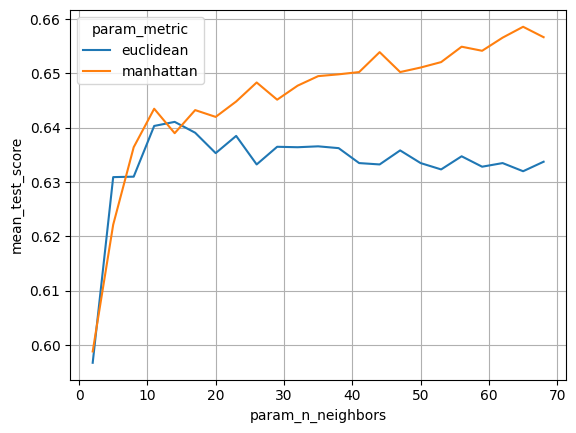

In [29]:
# 이를 차트로 그려봅시다.
sns.lineplot(x = 'param_n_neighbors', y = 'mean_test_score', data = temp
             , hue = 'param_metric' )
plt.grid()
plt.show()

### (3) 실습 : Grid Search

* 사용할 알고리즘 : decision tree
* 튜닝 방식 : Grid Search
    * 조절해 볼 만한 파라미터 : 아래 값의 범위에서 튜닝을 시도하세요.
        * max_depth : 1 ~ 15 ▶ range(1,16)
        * min_samples_leaf : 10, 30, 50

In [34]:
# 1) 파라미터를 dictionary형태로 선언
params = { 'max_depth' : [i for i in range(16)]
    , 'min_samples_leaf' : [10, 30 ,50] }

In [35]:
# 2) 함수 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [36]:
# 3) 모델 선언
tree = DecisionTreeClassifier()

tree_gs = GridSearchCV(tree,
                    params,
                    cv = 3    # k-fold cross validation
                    ) # scoring을 생략하면, 기본값으로 분류는 accuracy, 회귀는 r2_score


In [37]:
# 4) 학습
tree_gs.fit(x_train_s, y_train)

c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
9 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Use

,estimator,DecisionTreeClassifier()
,param_grid,"{'max_depth': [0, 1, ...], 'min_samples_leaf': [10, 30, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [40]:
# 5) 선택된 best parameter는?
print(tree_gs.best_params_)

# 6) best parameter에서의 cv 성능은?
print(tree_gs.best_score_)

{'max_depth': 6, 'min_samples_leaf': 50}
0.7045


In [43]:
# 7) 예측 및 평가
pred = tree_gs.predict(x_val_s)
accuracy_score(y_val, pred)

0.691625

In [44]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[2625 1275]
 [1192 2908]]
              precision    recall  f1-score   support

       LEAVE       0.69      0.67      0.68      3900
        STAY       0.70      0.71      0.70      4100

    accuracy                           0.69      8000
   macro avg       0.69      0.69      0.69      8000
weighted avg       0.69      0.69      0.69      8000

